### Introduction
Nama: Andrian Tanjung

Batch: HCK 004

##### Dataset Overview
The dataset comprises of product reviews on the Tokopedia e-commerce platform, provided by individuals who made purchases from various online shops available.

##### Objective
The objective is to determine the market sentiment towards the product by classifying sentences as either positive , neutral or negative feedback.

### Import Libraries

In [430]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import tensorflow as tf
import nltk

## pre-process
from nltk import tokenize, word_tokenize
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
from keras import regularizers
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding
from sklearn import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from nltk.corpus import stopwords
from imblearn.under_sampling import NearMiss
from sklearn import preprocessing
from keras.initializers import VarianceScaling

## evaluasi
from sklearn.metrics import confusion_matrix ,accuracy_score, roc_curve,roc_auc_score,precision_score, recall_score, classification_report, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, GRU, Dropout
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.utils as ku

## warning
import warnings 
warnings.filterwarnings(action='ignore')

## save
import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Loading and Overview

In [431]:
df = pd.read_csv('product_reviews.csv') ## read the csv
df.head() 

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


In [432]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40607 entries, 0 to 40606
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    40607 non-null  int64 
 1   text          40607 non-null  object
 2   rating        40607 non-null  int64 
 3   category      40607 non-null  object
 4   product_name  40607 non-null  object
 5   product_id    40607 non-null  int64 
 6   sold          40593 non-null  object
 7   shop_id       40607 non-null  int64 
 8   product_url   40607 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.8+ MB


From the dataset info we can see that:
- The entries data is 40607 and have 9 columns in total. From this 9 columns there are few that we can drop since it does not related with our objective.
- Even though 'rating' column is integer but in actual it represents categorical and same as 'shop_id' and 'product_id' which should be an object data type.
- 'Sold' column should be an integer but instead we got an object data type, but we can ignore this since we are not focusing on this column

In [433]:
df.isnull().sum()
## looking at missing value

Unnamed: 0       0
text             0
rating           0
category         0
product_name     0
product_id       0
sold            14
shop_id          0
product_url      0
dtype: int64

In [434]:
df.duplicated().sum()
## looking at duplicate entries

0

In [435]:
df[df.isnull().any(axis=1)]
## looking at missing value on the data

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
12538,12621,Biar bintang Yang berbicara......,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12539,12622,"Mantabs, sandal sesuai ukuran, warna dan kuali...",5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12540,12623,pas mantappppp ukuran dan kualitas nya sesuai ...,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12541,12624,"Puas, gan... cuma sayangnya agak kekecilan, pa...",4,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12542,12625,Pembelian kedua...Good sesuai iklan...sandal e...,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12543,12626,Produk dah keterima. Mantappp pokok na mah.......,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12544,12627,Terbaik lah udah yang ke 2x belanja dan selalu...,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12545,12628,"Lumayan bagus, mudah2an awet",4,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12546,12629,barang bagus sesuai diskripsi meskipun ada ken...,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...
12547,12630,Fast respon. Packing rapih. Trima kasih,5,fashion,SABERTOOTH Sandal Gunung Traventure Intera Hit...,415710312,NaN,157834,https://www.tokopedia.com/sabertooth/sabertoot...


Out of the total entries, only 14 (less than 1%) were found to be missing in the 'sold' column. It is observed that the missing values occur specifically for certain 'shop_id' and 'product_id'. Therefore, it can be concluded that the missing values follow the MAR type of missingness, which can be managed by dropping the respective data entries.

There is no duplicate data on the dataset

In [436]:
df.describe(include='object')
## overview of categorical columns

,text,category,product_name,sold,product_url
count,40607,40607,40607,40593,40607
unique,37301,5,3647,305,3664
top,Barang sesuai deskripsi,elektronik,TINTA / CATRIDGE HP 680 BLACK / COLOR ORIGINAL...,"3,2rb",https://www.tokopedia.com/sjkomputer/tinta-cat...
freq,57,15897,1312,1794,1312


From the data above we can see that:
- 'text' column has 40607 but the unique data is 37301. We can conclude that some individuals commented the same reply when they reviewed the product. 
- There are 5 categories product on the dataset and the most frequent being bought is electronic category.
- There are 3647 unique product sold on the platform.
- The most sold product is printer ink which is sold as much as 1312.

Things need to be done on data cleaning:
- handle missing value
- remove some irrelevant columns
- change some columns data type

### General Data Cleaning

In [437]:
df.dropna(inplace=True)
## handling missing value

In [438]:
df.isnull().sum()

Unnamed: 0      0
text            0
rating          0
category        0
product_name    0
product_id      0
sold            0
shop_id         0
product_url     0
dtype: int64

In [439]:
df.drop(columns=['Unnamed: 0','product_url'], inplace=True)
## removing unnecesarry columns

In [440]:
df.head()

,text,rating,category,product_name,product_id,sold,shop_id
0,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837
1,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109
2,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109
3,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395
4,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999


This is the cleanded dataframe that we will use for exploratory data analysis

### Exploratory Data Analysis

In [441]:
df_preprocess = df.copy()
## making a copy from original dataframe

In [442]:
df_preprocess.rating.value_counts()
## looking at the data from value

5    30300
4     7543
3     1825
1      543
2      382
Name: rating, dtype: int64

It seems like most of individuals are giving 5 point rating. We can also conclude that 5-point is the highest, 1-point is the lowest and 3-point as neutral result. So we can make a numerical code as representation where 1-2-point as 0 or negative, 3-point as 1 or neutral, 4-5-point as 2 or positive. 

In [443]:
df_preprocess['sentiment'] = df_preprocess['rating'].replace({1:0, 2:0, 3:1, 4:2, 5:2})
## make representation from rating

In [444]:
df_preprocess.sentiment.value_counts()
## see the target distribution

2    37843
1     1825
0      925
Name: sentiment, dtype: int64

As we can see from the data above that most of the sentiments are positive, the imbalanced data needs to be handled.

In [445]:
df_preprocess.category.value_counts()

elektronik     15897
fashion         8896
olahraga        7838
handphone       6136
pertukangan     1826
Name: category, dtype: int64

There are only 5 categories on this dataset and the most bought is electronic category.

In [446]:
df_preprocess.text

0                   Barang sesuai pesanan dan cepat sampai
1                                 Barang bagus harga murah
2          Paket rapi...mantap....cepat....sampe ke tujuan
3                               ya saya puas dgn barangnya
4                             Responya luar biasa b mantap
                               ...                        
40602                  gak bisa ditutup.. ukuran gak pas..
40603    Penjual krg peduli dan brg jelek. Brg yg dikir...
40604    pelayanan kurang sigap, berhari2 dr nanya baik...
40605    barang yg dikirim tsk sesuai wrn, kl memang dr...
40606    Pihak penjual memberikan respon yang buruk kep...
Name: text, Length: 40593, dtype: object

These are the feedback comments from the user who have bought the products. We need to evaluate some words as we might know that a lot of people did some typo, use slang, abbreviation etc.

### Data Pre-process

In [447]:
kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')
kamus_sendiri = pd.read_csv('kamus.csv')
## csv for outsource dictionary for handling text

In [448]:
kamus_alay.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [449]:
kamus_sendiri.head()

,slang,formal
0,gak,tidak
1,dgn,dengan
2,b,barang
3,krg,kurang
4,brg,barang


We outsource a dictionary to help us handling the text column and with additional of our own dictionary from our EDA. The dictionary is in dataframe shape where we will make it into a list so it can get into the function.

In [450]:
dict_informal1 = pd.Series(kamus_alay.formal.values, index=kamus_alay.slang).to_dict()
dict_informal2 = pd.Series(kamus_sendiri.formal.values, index=kamus_sendiri.slang).to_dict()
## making dataframe into series

In [451]:
## making a function to remove unnecessary characters and transforming colloquial word to its common form
def clean_text(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"    # emoticons
        u"\U0001F300-\U0001F5FF"    # symbols & pictographs
        u"\U0001F680-\U0001F6FF"    # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
        u"\U00002500-\U00002BEF"    # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"                  
        u"\u3030"
                      "]+", re.UNICODE)

    text = text.lower()                                                                     # change to lower case
    text = re.sub(emoj, '', text)                                                           # remove emoji
    text = re.sub(r'(.)\1{2,}', r'\1', text)                                                # change repeated words into one word
    text = re.sub("[0-9]", " ", text)                                                       # remove numbers
    text = re.sub("'s", " ", text) 
    text = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", text)                                         # remove power character
    text = re.sub("[^\w\s]*[_,.!?#&;:><+-/)/(\'\"]", " ", text)                             # remove weird string whitespace
    text = ' '.join([re.sub(r'nya$|ny$', '', i) for i in text.split()])                     # remove conjuction
    text = " ".join(dict_informal1[w] if w in dict_informal1 else w for w in text.split())  # replace based on dict_informal1
    text = " ".join(dict_informal2[w] if w in dict_informal2 else w for w in text.split())  # replace based on dict_informal2
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = re.sub(" +", " ", text.strip())                                                  # remove unnecessary white space
    return text


In [452]:
## making a stop word function
stop_words = set(stopwords.words('indonesian'))

def clean_text1(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    text = re.sub(r'\s+',' ',text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

We have created two functions to preprocess our text data: the first one performs case folding and removes different types of punctuation, while the second function removes stop words. These functions are now ready to be applied to the 'clean' column.

In [453]:
df_preprocess['clean'] = df_preprocess.text.apply(clean_text)
## applied the 1st function to targeted text

df_preprocess['clean'] = df_preprocess.clean.apply(clean_text1)
## applied the 2nd function to targeted text

In [454]:
idx = df_preprocess.text.sample(10).index

print('Before function applied:')
for i in idx:
    print(i, df_preprocess.text[i])
    
print('\nAfter function applied:')
for i in idx:
    print(i, df_preprocess.clean[i])

Before function applied:
19924 Good produk...👍 sesuai gambar
2728 Trima kasih barang nya sudah sampai dan seauai dengan deakripsi
12257 Mantapppp banget hihihi dpt yang lagi flashsale pula. I love bata
31662 Good sesuai yang diorderrrr
39852 Mantap bung barangnya, sesuai ekspektasi recommended seller dah pokoknya ni warung 👍👍👍
11586 makasih gan 
barang sudah sampai dengan selamat 
sukses selalu
5278 Karuan beli produk china aja...barange parah enteng kya krupuk suara speaker parah.layar kya mainan bocah
26140 Sesuai dengan deskripsi, Berfungsi dengan baik. Cepat sampai, Recommended Seller.
11757 Pengiriman sangat cepat , produk baik
23791 Oke sesuai dan pengirman cepat tepat

After function applied:
19924 good produk sesuai gambar
2728 terima kasih barang seauai deakripsi
12257 mantap hihihi flashsale love bata
31662 good sesuai diorder
39852 mantap barang sesuai ekspektasi recommended seller deh pokok nih warung
11586 terima kasih barang selamat sukses
5278 karuan beli produk china ba

We can see the comparison before and after the function being applied. Now we have the clean column which contains text that has been preprocess. Let see most commong word on each sentiment to check if there is any unnecessary words left behind.

--- Most Common Word on Positive Sentiment ---

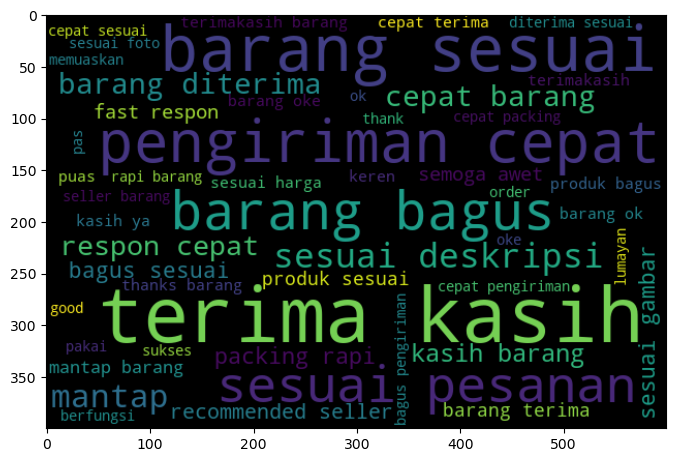

In [455]:
positive_preprocess =  df_preprocess[(df_preprocess['sentiment']==2)]   ## variable to be put on wordcloud

plt.figure(figsize = (8,10)) 

w_cloud = WordCloud(background_color='black', min_font_size = 3,                ## wordcloud function
                    max_words = 50 , width = 600 ,
                    height = 400).generate(" ".join(positive_preprocess.clean))

plt.imshow(w_cloud,interpolation = 'bilinear')

--- Most Common Word on Neutral Sentiment ---

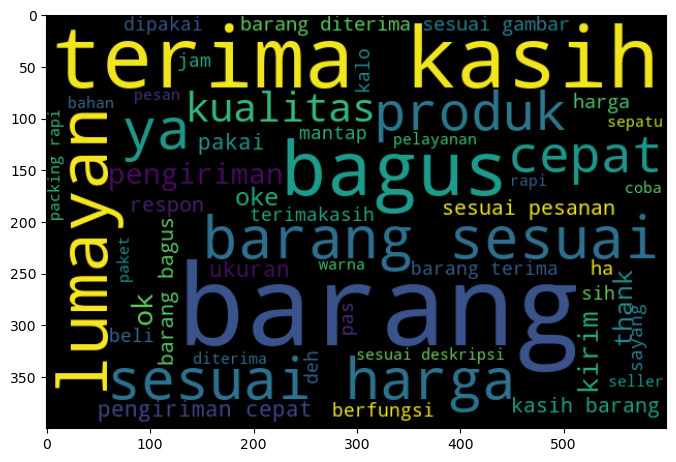

In [456]:
neutral_preprocess =  df_preprocess[(df_preprocess['sentiment']==1)]   ## variable to be put on wordcloud

plt.figure(figsize = (8,10)) 

w_cloud = WordCloud(background_color='black', min_font_size = 3,                ## wordcloud function
                    max_words = 50 , width = 600 ,
                    height = 400).generate(" ".join(neutral_preprocess.clean))

plt.imshow(w_cloud,interpolation = 'bilinear')

--- Most Common Word on Negative Sentiment ---

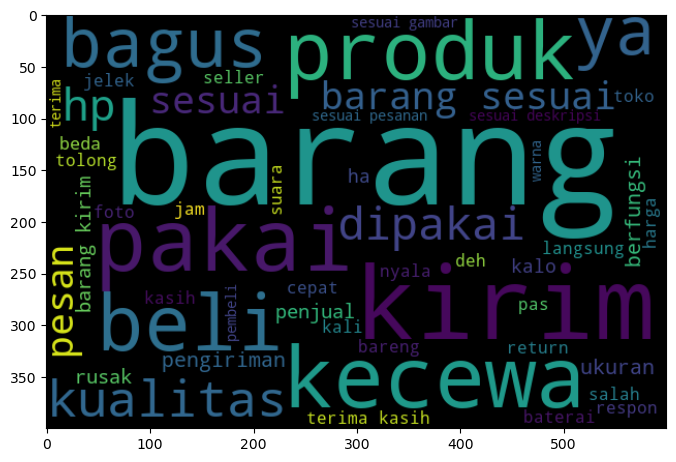

In [457]:
negative_preprocess =  df_preprocess[(df_preprocess['sentiment']==0)]   ## variable to be put on wordcloud

plt.figure(figsize = (8,10)) 

w_cloud = WordCloud(background_color='black', min_font_size = 3,                ## wordcloud function
                    max_words = 50 , width = 600 ,
                    height = 400).generate(" ".join(negative_preprocess.clean))

plt.imshow(w_cloud,interpolation = 'bilinear')

From the wordcloud visualization, we can observe that the word 'barang' appears frequently across all sentiments. Therefore, we can drop this word as it does not provide meaningful insights. Additionally, there are other words that lack meaning and can also be removed.

For negative sentiment analysis, we will use a different stopword function to account for words that may not necessarily indicate a negative sentiment. We will interpret the results based on this adjusted stopword list.

In [458]:
## making a new stop word function for positive and neutral sentiment
stop_words = set(stopwords.words('indonesian'))
my_stopwords = {'barang', 'kalo', 'deh','ya'}
stop_words.update(my_stopwords)

def clean_text2(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    text = re.sub(r'\s+',' ',text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [459]:
## making a new stop word function for negative sentiment
stop_words_negative_sentiment = set(stopwords.words('indonesian'))
my_stopwords = {'barang', 'kalo', 'deh','ya', 'bagus', 'kasih', 'sesuai', 'ta', 'ca'}
stop_words.update(my_stopwords)

def clean_text3(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    text = re.sub(r'\s+',' ',text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [460]:
df_preprocess['clean'] = pd.Series(dtype='object')                  ## change into series first for applying function  

df_preprocess['clean'] = df_preprocess['clean'].combine_first(      ## apply clean_text2 function to positive_preprocess
    positive_preprocess['clean'].apply(lambda x: clean_text2(x))
)
df_preprocess['clean'] = df_preprocess['clean'].combine_first(      ## apply clean_text2 function to neutral_preprocess
    neutral_preprocess['clean'].apply(lambda x: clean_text2(x))
)
df_preprocess['clean'] = df_preprocess['clean'].combine_first(      ## apply clean_text3 function to negative_preprocess
    negative_preprocess['clean'].apply(lambda x: clean_text3(x))
)

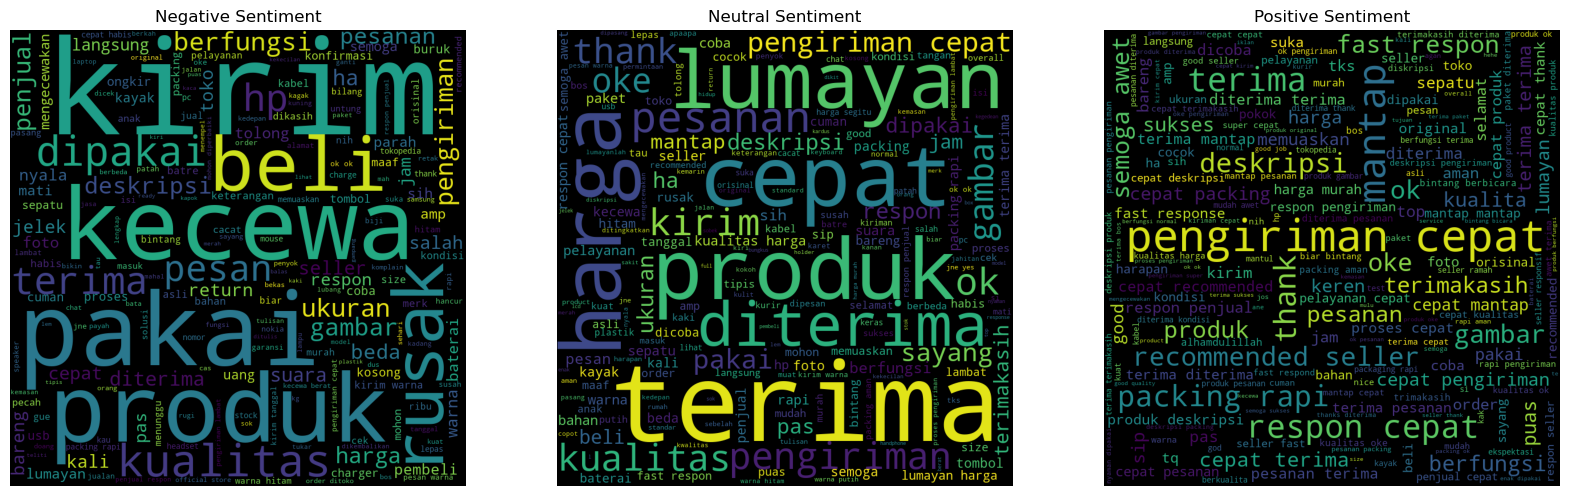

In [466]:
## calling the variable again to get updated result from above
negative_preprocess =  df_preprocess[(df_preprocess['sentiment']==0)]['clean']
neutral_preprocess =  df_preprocess[(df_preprocess['sentiment']==1)]['clean'] 
positive_preprocess =  df_preprocess[(df_preprocess['sentiment']==2)]['clean']

## generate WordCloud for each sentiment
negative_cloud = WordCloud(width=800, height=800, background_color='black').generate(' '.join(negative_preprocess))
neutral_cloud = WordCloud(width=800, height=800, background_color='black').generate(' '.join(neutral_preprocess))
positive_cloud = WordCloud(width=800, height=800, background_color='black').generate(' '.join(positive_preprocess))

## plot WordClouds
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes[0].imshow(negative_cloud)
axes[0].set_title('Negative Sentiment')
axes[0].axis('off')

axes[1].imshow(neutral_cloud)
axes[1].set_title('Neutral Sentiment')
axes[1].axis('off')

axes[2].imshow(positive_cloud)
axes[2].set_title('Positive Sentiment')
axes[2].axis('off')

plt.show()


After applying the second updated function, the most common words on each sentiment appear to be more meaningful. For instance, positive sentiment is associated with the word 'terima kasih', which indicates that the buyer is expressing appreciation and satisfaction. On the other hand, neutral sentiment's words have some similarity with positive sentiment, and negative sentiment is associated with the words 'kecewa' and 'dikirim', which convey disappointment and delivery-related issues.

### Handling Imbalance Data

Based on the EDA results where the data is imbalance, so we either use undersampling or oversampling method. Based on preserving the original data we will perform undersampling on all classes to achieve a balanced dataset (because oversampling will create unorganic data result). To ensure that the undersampling is representative, we will use electronic products as the benchmark for sentiment class undersampling, as it is the most commonly purchased category.

class 2 (positive): 37843 data

class 1 (neutral): 1825 data

class 0 (negative): 925 data

In [467]:
sentimen2_electronic = df_preprocess[                   ## variable that contains sentiment class 2 with electronic purchase
    (df_preprocess['sentiment'] == 2) &         
    (df_preprocess['category'] == 'elektronik')
].shape[0]                                                 

sentimen1_electronic = df_preprocess[                   ## variable that contains sentiment class 1 with electronic purchase
    (df_preprocess['sentiment'] == 1) &
    (df_preprocess['category'] == 'elektronik')
].shape[0]

sentimen0_electronic = df_preprocess[                   ## variable that contains sentiment class 0 with electronic purchase
    (df_preprocess['sentiment'] == 0) &
    (df_preprocess['category'] == 'elektronik')
].shape[0]

print('Class 2 sentiment that bought electronic product have', sentimen2_electronic, 'data')
print('Class 1 sentiment that bought electronic product have', sentimen1_electronic, 'data')
print('Class 0 sentiment that bought electronic product have', sentimen0_electronic, 'data')

Class 2 sentiment that bought electronic product have 15305 data
Class 1 sentiment that bought electronic product have 404 data
Class 0 sentiment that bought electronic product have 188 data


In order to make the data balance so we need to undersampling all classes into similar data. Here I will not make all the sentiments data all are the same because the lowest number (188 data) is small data. We will make class 2 into 267 data and class 1 into 321 data.

In [468]:
sentimen2_electronic = df_preprocess[                   ## variable that contains sentiment class 2 with electronic purchase
    (df_preprocess['sentiment'] == 2) &         
    (df_preprocess['category'] == 'elektronik')
].sample(267)                                           ## taking sample from sentiment class 2

sentimen1_electronic = df_preprocess[                   ## variable that contains sentiment class 2 with electronic purchase
    (df_preprocess['sentiment'] == 1) &         
    (df_preprocess['category'] == 'elektronik')
].sample(321)                                           ## taking sample from sentiment class 1

sentimen0_electronic = df_preprocess[                   ## variable that contains sentiment class 2 with electronic purchase
    (df_preprocess['sentiment'] == 0) &         
    (df_preprocess['category'] == 'elektronik')
].sample(188)                                           ## taking sample from sentiment class 0

In [469]:
df_balance = pd.concat([sentimen2_electronic, sentimen1_electronic, sentimen0_electronic]).reset_index(drop=True)
df_balance.shape

(776, 10)

We now have a new dataframe with 776 entries, where the sentiment classes are considered balanced and all of the entries belong to the electronic category that represent the population data on previous dataset.

### Text Vectorization and Embedding

In [470]:
X_train, X_test, y_train, y_test = train_test_split(df_balance.clean, df_balance.sentiment, train_size=0.69, random_state=1, stratify=df_balance.sentiment)
## split XY train-test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.69, random_state=11, stratify=y_train)
## split XY train-validation

In [471]:
# Get Vocabularies
Vectorize = CountVectorizer(lowercase=False)
X_train_vec = Vectorize.fit_transform(X_train)
X_train_vec

<369x706 sparse matrix of type '<class 'numpy.int64'>'
	with 1859 stored elements in Compressed Sparse Row format>

In [472]:
print("No of vocabulary in total : ", len(Vectorize.vocabulary_.keys()))
print("Max length of words in one sentence : ", max([len(i.split(" ")) for i in X_train]))

No of vocabulary in total :  706
Max length of words in one sentence :  33


Based on the count vectorizer above, the sparse matrix has 369 rows and the feature or dimenstion is 775 (represent the number of unique features) and the most words on one sentences from the balance data is 36 words.

In [473]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=775,
                                       split="whitespace",
                                       ngrams=5,
                                       output_mode="int",
                                       output_sequence_length=36,
                                       input_shape=(1,)
                                       )
text_vectorization.adapt(X_train)

In the text vectorization parameter that been choosen:
- max token: represent the maximum of vocabulary which in this case is 775
- split: the layer will split every words when it finds a space
- ngrams: 5 which mean the layer will find the 4 words after and before to find the best corresponds of neighbor words
- output sequence length: needs to be the same with the maximum words on a sentence in the feature 

In [474]:
# Embedding
embedding = Embedding(input_dim=775,
                      output_dim=128,
                      embeddings_initializer="glorot_uniform",
                      input_length=36
                      )

In the embedding parameter that been choosen: 
- input dim: represent the vocab on the data we have, in this case is 775
- output dim: using the common number 128
- embeddings initializer: using glorot_uniform because maintain the variance of the activations and gradients throughout the network which will prevent vanishing or exploding* 
- input length: needs to be the same with the maximum words on a sentence in the feature 

*https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/

So we have convert all the text into numeric with weighted value which the only way to be able understand and process the model. And now we are ready to move on to model. In here we will be using layer GRU and LSTM and compare which model is better for this dataset.

### Modeling

In order to make the work easier, we will change the target to each columns using one hot encoder.

In [475]:
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)
## make the target into the same number as the values

In [476]:
# Train Program
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe))

## Shuffle train dataset.
train_dataset = train_dataset.shuffle(buffer_size=775).batch(64)

## Test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe))
test_dataset = test_dataset.batch(64)

## Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe))
val_dataset = val_dataset.batch(64)

-- GRU Layer --

--- Before Tuning ---

In [477]:
model_GRU = Sequential()
model_GRU.add(text_vectorization)
model_GRU.add(embedding)
model_GRU.add(GRU(243, return_sequences=True))
model_GRU.add(GRU(81, return_sequences=True))
model_GRU.add(GRU(27, return_sequences=True))
model_GRU.add(GRU(9))
model_GRU.add(Dense(3, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy',optimizer='adam',metrics='categorical_accuracy')

The above architecture model uses a sequential model that begins with a text_vectorization layer, which receives an input of 755 features and embedding layer afterwards to give some weight on the words to have meaning so the model can know which word have connection with other words. The model then adds four hidden layers with 243, 81, 27, and 9 neurons, respectively. The final layer uses softmax activation as the output is multi-class with 3 features.

At the model compile
- using categorical_crossentropy: because of multi-class classification and the each classes is mutually exclusive*
- using adam optimizer: most commonly used and perform well**
- using categorical_accuracy metric: because of multi-class classification

*https://machinelearningmastery.com/cross-entropy-for-machine-learning/

** https://arxiv.org/abs/1412.6980 

In [478]:
history = model_GRU.fit(train_dataset, epochs=33, validation_data=val_dataset)

Epoch 1/33
6/6 [==============================] - 7s 385ms/step - loss: 1.0712 - categorical_accuracy: 0.3713 - val_loss: 1.0532 - val_categorical_accuracy: 0.4096
Epoch 2/33
6/6 [==============================] - 1s 187ms/step - loss: 1.0739 - categorical_accuracy: 0.4201 - val_loss: 1.0617 - val_categorical_accuracy: 0.4036
Epoch 3/33
6/6 [==============================] - 1s 197ms/step - loss: 1.0485 - categorical_accuracy: 0.4146 - val_loss: 1.0551 - val_categorical_accuracy: 0.3916
Epoch 4/33
6/6 [==============================] - 1s 192ms/step - loss: 1.0573 - categorical_accuracy: 0.4173 - val_loss: 1.0572 - val_categorical_accuracy: 0.3855
Epoch 5/33
6/6 [==============================] - 1s 213ms/step - loss: 1.0440 - categorical_accuracy: 0.4472 - val_loss: 1.0583 - val_categorical_accuracy: 0.3976
Epoch 6/33
6/6 [==============================] - 1s 200ms/step - loss: 1.0478 - categorical_accuracy: 0.4309 - val_loss: 1.0593 - val_categorical_accuracy: 0.4157
Epoch 7/33
6/6 [

Text(0.5, 0, 'Epoch')

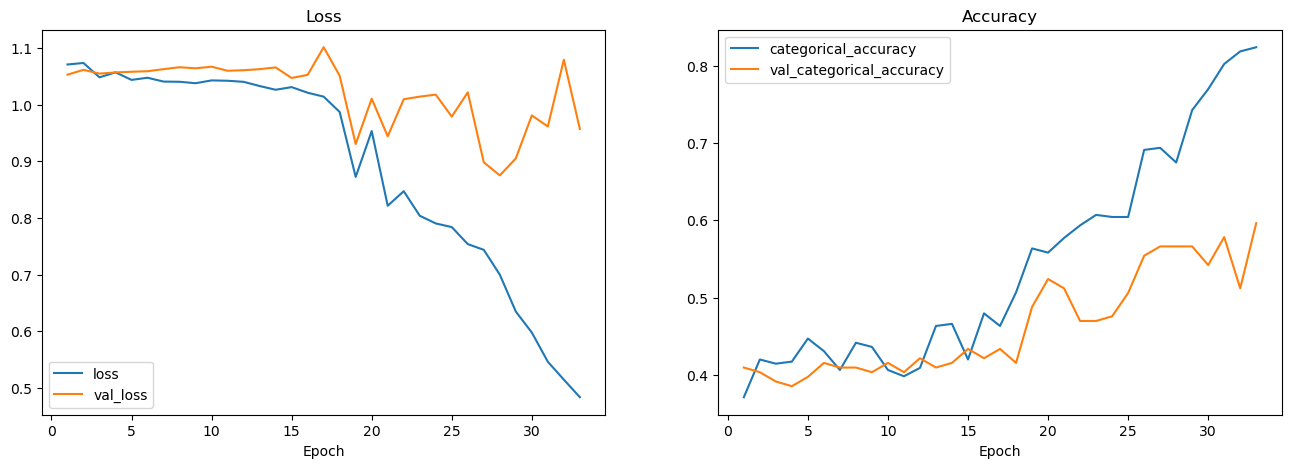

In [479]:
epoch=33

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history.history['categorical_accuracy'],label='categorical_accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
## visualization of model validation and train result

In [480]:
model_GRU.evaluate(val_dataset)

3/3 [==============================] - 0s 45ms/step - loss: 0.9572 - categorical_accuracy: 0.5964


[0.9571965336799622, 0.5963855385780334]

As seen from the graph above, the model is heavily overfitting the training data. Therefore, we need to make further modifications in order to obtain a better-fitting model that can be applied to different datasets. Let's see if we modify using parameter tunning.

--- After Tunning ---

In [481]:
model_GRU_tun = Sequential()
model_GRU_tun.add(text_vectorization)
model_GRU_tun.add(embedding)
model_GRU_tun.add(GRU(81, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model_GRU_tun.add(Dropout(0.5))
model_GRU_tun.add(tf.keras.layers.BatchNormalization())
model_GRU_tun.add(GRU(27, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model_GRU_tun.add(Dropout(0.5))
model_GRU_tun.add(tf.keras.layers.BatchNormalization())
model_GRU_tun.add(GRU(9, kernel_regularizer=regularizers.l2(0.001)))
model_GRU_tun.add(Dropout(0.3))
model_GRU_tun.add(tf.keras.layers.BatchNormalization())
model_GRU_tun.add(Dense(3, activation='softmax'))

model_GRU_tun.compile(loss='categorical_crossentropy', optimizer='adam', metrics='categorical_accuracy')

In [484]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.003)

# Train the model
history = model_GRU_tun.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[early_stop, reduce_lr])

Epoch 1/30
6/6 [==============================] - 0s 81ms/step - loss: 1.3244 - categorical_accuracy: 0.4173 - val_loss: 1.2185 - val_categorical_accuracy: 0.3855 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 0s 79ms/step - loss: 1.2757 - categorical_accuracy: 0.4417 - val_loss: 1.2203 - val_categorical_accuracy: 0.3976 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 0s 78ms/step - loss: 1.2825 - categorical_accuracy: 0.4363 - val_loss: 1.2169 - val_categorical_accuracy: 0.4036 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - 0s 77ms/step - loss: 1.2274 - categorical_accuracy: 0.4472 - val_loss: 1.2079 - val_categorical_accuracy: 0.3976 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 0s 79ms/step - loss: 1.2361 - categorical_accuracy: 0.4499 - val_loss: 1.2122 - val_categorical_accuracy: 0.3735 - lr: 0.0010
Epoch 6/30
6/6 [==============================] - 0s 85ms/step - loss: 1.1845 - categorical_accuracy: 0.4444 - val_loss:

Text(0.5, 0, 'Epoch')

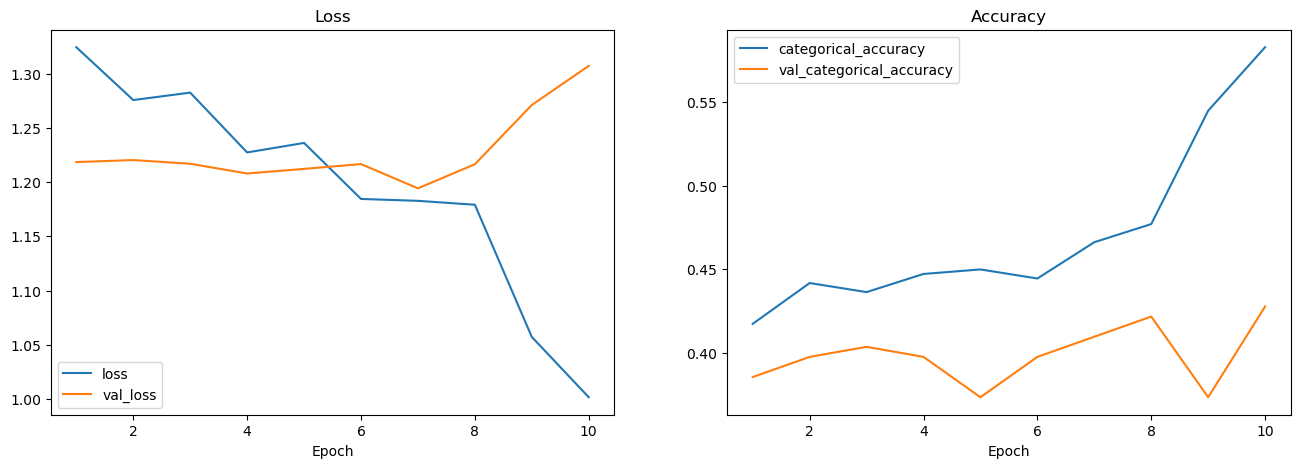

In [485]:
epoch=10

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history.history['categorical_accuracy'],label='categorical_accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
## visualization of model validation and train result

In [486]:
model_GRU_tun.evaluate(val_dataset)

3/3 [==============================] - 0s 35ms/step - loss: 1.1942 - categorical_accuracy: 0.4096


[1.1942366361618042, 0.40963855385780334]

As we can see, the accuracy of the model after hyperparameter tuning is not better than before. However, the model is now less overfit and has twice the learning speed. The modifications we made during hyperparameter tuning are:
- dropping some layers to make the model less complex.
- adding kernel L2 regularizer to reduce the number of trained neuron weights, making the model more robust to noise.
- adding dropout to reduce the weights on neurons, similar to adding kernel regularization, to make the model more robust to noise.
- adding batch normalization to normalize the inputs to each layer in a batch. This helps reduce the model's dependence on specific weights and biases, which are the main causes of overfitting.*
- using EarlyStopping  and ReduceLROnPlateau; early stopping is to help save the computerization after reaching specific values that shows the capacity of model result, and learning rate can help the model converge faster and avoid getting stuck in a local minimum.**

From here we find out why using the parameter tunning such as; kernel_regularizer, dropout and batch_normalization helps the model to have a better training time and less overfit, because they reduce the weight of neurons and biases towards the learning process.

*https://arxiv.org/pdf/1801.05134.pdf

**https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/ and https://pub.towardsai.net/keras-earlystopping-callback-to-train-the-neural-networks-perfectly-2a3f865148f7

-- LSTM Layer --

--- Before Tunning ---


In [487]:
model_LSTM = Sequential()
model_LSTM.add(text_vectorization)
model_LSTM.add(embedding)
model_LSTM.add(LSTM(729, return_sequences=True))
model_LSTM.add(LSTM(243, return_sequences=True))
model_LSTM.add(LSTM(81, return_sequences=True))
model_LSTM.add(LSTM(27))
model_LSTM.add(Dense(3, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy',optimizer='SGD',metrics='categorical_accuracy')

The above architecture model uses a sequential model that begins with a text_vectorization layer, which receives an input of 755 features and embedding layer afterwards to give some words more meaning so the model learn better. The model then adds four hidden layers with 729, 243, 81, and 27 neurons, respectively. The final layer uses softmax activation as the output is multi-class with 3 features. The model sequences is the same with the GRU layer, the only difference is the neuron put on the layer.

The model compiler parameters are the same except in here using SGD. Using SGD because it less prone to overfitting than Adam, especially on smaller datasets and the algorithm is simpler than Adam.*

*https://www.ruder.io/optimizing-gradient-descent/

In [488]:
history = model_LSTM.fit(train_dataset, epochs=33, validation_data=val_dataset)

Epoch 1/33
6/6 [==============================] - 14s 2s/step - loss: 1.1000 - categorical_accuracy: 0.2846 - val_loss: 1.0939 - val_categorical_accuracy: 0.4157
Epoch 2/33
6/6 [==============================] - 13s 2s/step - loss: 1.0929 - categorical_accuracy: 0.4119 - val_loss: 1.0884 - val_categorical_accuracy: 0.4157
Epoch 3/33
6/6 [==============================] - 12s 2s/step - loss: 1.0885 - categorical_accuracy: 0.4119 - val_loss: 1.0848 - val_categorical_accuracy: 0.4157
Epoch 4/33
6/6 [==============================] - 12s 2s/step - loss: 1.0857 - categorical_accuracy: 0.4119 - val_loss: 1.0820 - val_categorical_accuracy: 0.4157
Epoch 5/33
6/6 [==============================] - 13s 2s/step - loss: 1.0828 - categorical_accuracy: 0.4119 - val_loss: 1.0801 - val_categorical_accuracy: 0.4157
Epoch 6/33
6/6 [==============================] - 13s 2s/step - loss: 1.0812 - categorical_accuracy: 0.4119 - val_loss: 1.0785 - val_categorical_accuracy: 0.4157
Epoch 7/33
6/6 [============

Text(0.5, 0, 'Epoch')

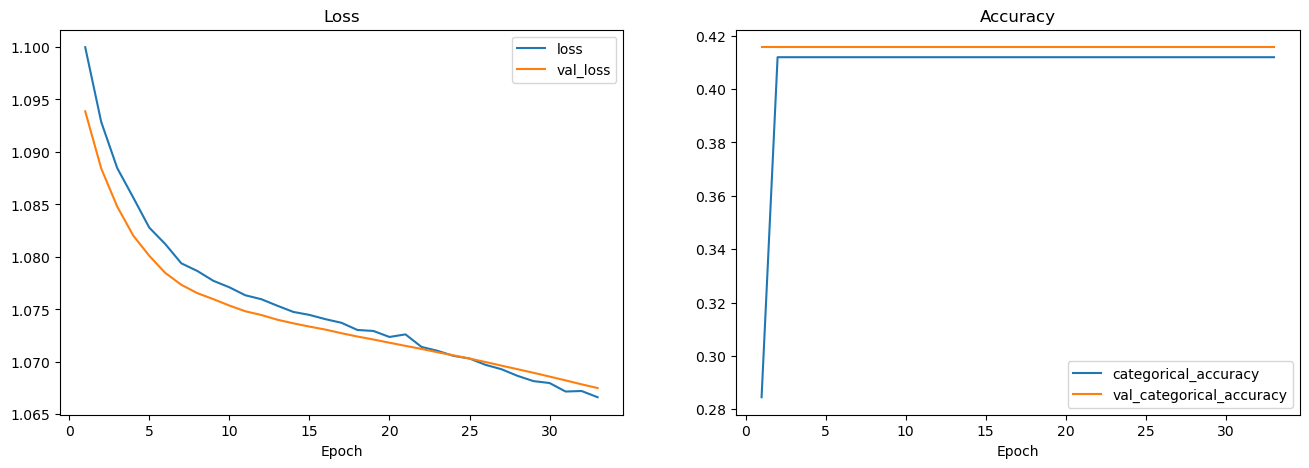

In [489]:
epoch=33

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history.history['categorical_accuracy'],label='categorical_accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
## visualization of model validation and train result

As we can see from the graph above, the loss is keep decreasing and the accuracy is static, it means the model is overfitting cause there is a vanishing gradient on the accuracy. Let see the result with hyper paramater tunning.

--- After Tunning ---

In [490]:
model_LSTM_tun = Sequential()
model_LSTM_tun.add(text_vectorization)
model_LSTM_tun.add(embedding)
model_LSTM_tun.add(LSTM(81, return_sequences=True, kernel_regularizer=regularizers.L1L2(0.01)))
model_LSTM_tun.add(Dropout(0.5))
model_LSTM_tun.add(tf.keras.layers.BatchNormalization())
model_LSTM_tun.add(LSTM(27, return_sequences=True, kernel_regularizer=regularizers.L1L2(0.01)))
model_LSTM_tun.add(Dropout(0.5))
model_LSTM_tun.add(tf.keras.layers.BatchNormalization())
model_LSTM_tun.add(LSTM(9, kernel_regularizer=regularizers.L1L2(0.01)))
model_LSTM_tun.add(Dropout(0.5))
model_LSTM_tun.add(tf.keras.layers.BatchNormalization())
model_LSTM_tun.add(Dense(3, activation='softmax'))

model_LSTM_tun.compile(loss='categorical_crossentropy', optimizer='SGD', metrics='categorical_accuracy')

In [491]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model_LSTM_tun.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[early_stop, reduce_lr])

Epoch 1/30
6/6 [==============================] - 6s 306ms/step - loss: 34.6463 - categorical_accuracy: 0.3279 - val_loss: 33.9734 - val_categorical_accuracy: 0.3916 - lr: 0.0100
Epoch 2/30
6/6 [==============================] - 1s 140ms/step - loss: 34.2263 - categorical_accuracy: 0.3659 - val_loss: 33.6912 - val_categorical_accuracy: 0.3795 - lr: 0.0100
Epoch 3/30
6/6 [==============================] - 1s 127ms/step - loss: 33.9268 - categorical_accuracy: 0.3631 - val_loss: 33.3903 - val_categorical_accuracy: 0.3916 - lr: 0.0100
Epoch 4/30
6/6 [==============================] - 1s 129ms/step - loss: 33.5309 - categorical_accuracy: 0.4038 - val_loss: 33.0912 - val_categorical_accuracy: 0.3916 - lr: 0.0100
Epoch 5/30
6/6 [==============================] - 1s 130ms/step - loss: 33.1169 - categorical_accuracy: 0.4255 - val_loss: 32.7908 - val_categorical_accuracy: 0.3735 - lr: 0.0100
Epoch 6/30
6/6 [==============================] - 1s 128ms/step - loss: 32.8869 - categorical_accuracy: 0

Text(0.5, 0, 'Epoch')

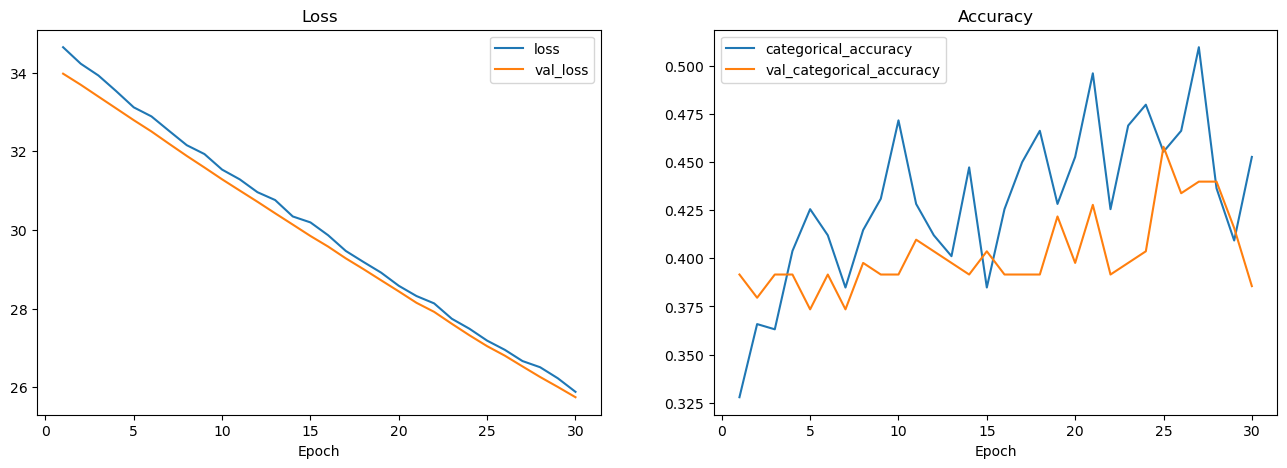

In [492]:
epoch=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history.history['categorical_accuracy'],label='categorical_accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
## visualization of model validation and train result

As we can see the graph with the hyper parameter tunning of LSTM model, there's an exploding gradient in the accuracy result. We can see that it happened between epochs 15 to 20 where there was a time when the accuracy went up in a parabolic way and get down right after. We can conclude that with the parameter tunning too the model is overfit and have bad accuracy on classifying the classes even though there are improvement on the training time with the help of the parameter tunning. 

The parameter tunning that I did:
- adding L1L2 kernel_regularizer because it combines L1 (Lasso) and L2 (Ridge) regularization. L1 regularization can help force some weights to be exactly zero, while L2 regularization can help prevent large weights from dominating the training process. By using both hoping that could get better result. *
- adding dropout
- adding batch_normalization
- using callbacks and learning rate 

*https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c


-- Conclusion From LSTM and GRU Layer --

As we can see that the better model for the manual balanced dataset is with LSTM layer. Both model after tunning are underfit and produce low score of accuracy. It might be because of the sample data we had earlier is not enough for the machine to learn or there's something off with the manual undersampling. Because of the limitation of time to do more research towards the better implementation towards the model, I decided to use the LSTM after tunning model for the model evaluation and inference because based on the result before LSTM is slightly have better accuracy classfication result.

### Model Evaluation

In [493]:
model_LSTM_tun.fit(train_dataset)   ## fit into train dataset

6/6 [==============================] - 1s 107ms/step - loss: 25.6711 - categorical_accuracy: 0.4336


In [494]:
model_test = model_LSTM_tun.predict(test_dataset)   ## calling back model
model_test

4/4 [==============================] - 1s 36ms/step


array([[0.31656113, 0.30862865, 0.37481022],
       [0.32152563, 0.31113917, 0.36733514],
       [0.31551227, 0.30798975, 0.37649795],
       [0.44606537, 0.41733545, 0.1365992 ],
       [0.32636353, 0.3207635 , 0.3528729 ],
       [0.321368  , 0.331674  , 0.34695795],
       [0.46042594, 0.39226133, 0.14731273],
       [0.44351944, 0.3908086 , 0.1656719 ],
       [0.3185659 , 0.30748767, 0.37394643],
       [0.3175662 , 0.3105221 , 0.37191164],
       [0.31281018, 0.30860308, 0.37858677],
       [0.3211484 , 0.31225505, 0.36659658],
       [0.42040855, 0.42339784, 0.15619358],
       [0.3232562 , 0.3091173 , 0.36762646],
       [0.34668848, 0.41358888, 0.23972268],
       [0.46441224, 0.3747263 , 0.16086143],
       [0.35757306, 0.5108833 , 0.1315437 ],
       [0.3392176 , 0.4114811 , 0.24930127],
       [0.42714489, 0.44120255, 0.1316525 ],
       [0.4419815 , 0.42548138, 0.13253708],
       [0.33027124, 0.321487  , 0.34824172],
       [0.31506535, 0.337604  , 0.34733066],
       [0.

As we know that the result is in probability which need to convert into scalar based on the highest probability on each row of the prediction. Since our clasification sentiments are 0:negative, 1:netral and 2:positive, the 3 columns above represent the same order. 

In [495]:
class_preds = np.argmax(model_test, axis=1)                     ## representing the predicted class for each input
one_hot_preds = ku.to_categorical(class_preds, num_classes=3)   ## convert this back to one-hot encoded format

In [496]:
print(classification_report(one_hot_preds, y_test_ohe, target_names=['sentiment 0','sentiment 1','sentiment 2']))

              precision    recall  f1-score   support

 sentiment 0       0.19      0.41      0.26        27
 sentiment 1       0.40      0.46      0.43        87
 sentiment 2       0.66      0.43      0.52       127

   micro avg       0.44      0.44      0.44       241
   macro avg       0.42      0.43      0.40       241
weighted avg       0.51      0.44      0.46       241
 samples avg       0.44      0.44      0.44       241



ROC AUC score
0.5750620971229171


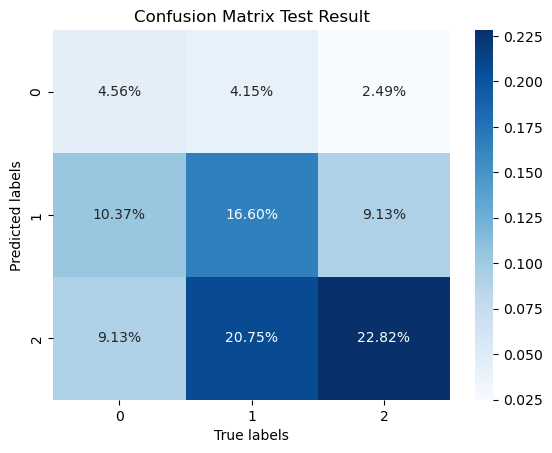

In [497]:
cf_matrix=confusion_matrix(class_preds, np.argmax(y_test_ohe, axis=1))                  
ax= plt.subplot()
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues', ax=ax)     
ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels') 
ax.set_title('Confusion Matrix Test Result')
print('ROC AUC score')
print(roc_auc_score(class_preds, y_test_ohe, multi_class='ovo'))

It can be seen from the ROC AUC score which only 53% indicates that the model still can classify each classes well. In general we can conclude that the model is underfit and there are many things need to be improved from the current model. Let us investigate why the model misclassifying classes.

In [498]:
df_pred = pd.DataFrame(X_test)                              
df_pred['result'] = y_test                                  ## making result column
df_pred['predicted'] = np.argmax(one_hot_preds, axis=1)     ## inverse onehot result back to array
df_pred.head()
## making new dataframe that consist of result and predicted

,clean,result,predicted
39,diterima test,2,2
103,works excellent thanks,2,2
436,gshshhsjdkdkkdjdjdjdj,1,2
703,kirim nomer situ tertulis alamat nomer untung ...,0,0
494,paking oke mantap berfungsi,1,2


In [499]:
df_pred[
    (df_pred['result']==0) &
    (df_pred['predicted']==1)
]
## calling the result=0 and predicted=1

,clean,result,predicted
721,kabel lumayan cuman cocok outdoor,0,1
741,pesan kirim cuman nih rugi,0,1
645,hancur dikasih bekas rusak payah korporatif ke...,0,1
716,packing rapi ķotor merk dideskripsi berdebu bo...,0,1
730,lumayanlah analog kiri stik berfungsi setting ...,0,1
674,frame clunky tombol mapping gabener segitiga d...,0,1
772,kualitas produk buruk pakai berfungsi,0,1
596,pesan joystick merk tech kirim beda merk nisuta,0,1
722,penjual pengechekan produk rusak semoga terula...,0,1
729,tulisan doang usb asli usb cuman warna port bi...,0,1


In [500]:
df_pred[
    (df_pred['result']==0) &
    (df_pred['predicted']==0)
]
## calling the result=0 and predicted=0

,clean,result,predicted
703,kirim nomer situ tertulis alamat nomer untung ...,0,0
648,maaf bintang dipasang laptop gambar dihasilkan...,0,0
613,sumpah kecewa parah sia sia gue bayar mahal go...,0,0
709,dipakai maaf balas beli mahal dipakai recommen...,0,0
612,return gara pointer mouse jalan alias ongkir r...,0,0
732,chat nota dikasih dimintain solusi dibalas kir...,0,0
717,deskripsi pakai langsung rusak kayak kuat tena...,0,0
649,packing rapi chat penjual cepat pengiriman lam...,0,0
767,spec gambar series mah battery terima series k...,0,0
689,diterima cepat seharus kirim check coba beli m...,0,0


From the data, I can assume that the reason why the model predicted class 1 which suppose to be class 0 is because the comments are more than 3 4 words, where if you see most of the people who commented negative only uses less than 3 words.

In [501]:
df_pred[
    (df_pred['result']==1) &
    (df_pred['predicted']==0)
]
## calling the result=1 and predicted=0

,clean,result,predicted
510,sayang kemasan penyok kecewa ane ane packing a...,1,0
403,pas dicoba putus menyambung mulu kegeser dikit...,1,0
320,saran jne yes hilangkan daftar kurir kurir jne...,1,0
267,kulit kabel sobek koneksi port usb pc nyala ma...,1,0
461,nama produk beda hahaha berhubung fungsi dipak...,1,0
335,produk ok ha seller bikin kecewa kesalahan lup...,1,0
420,kirim gambar deskripsi bentuk kabel audio peng...,1,0
379,pelayanan respond seller bintang kualitas prod...,1,0
553,tulisan usb dites detect usb speed pelan usb port,1,0
318,pengiriman cepat packing aman sayang beli mous...,1,0


In [502]:
df_pred[
    (df_pred['result']==1) &
    (df_pred['predicted']==1)
]
## calling the result=1 and predicted=1

,clean,result,predicted
507,berburu kancil ketemu jerapah kabel bingung,1,1
346,bengkokan tombol power dudukannyaa patah akali...,1,1
390,packing aman ha bungkus plastik hitam,1,1
469,pengiriman cepat diterima merk nisuta mtech,1,1
397,main sehari goyang stik kayak baut copot,1,1
433,berfungsi ha pesanan pesan hitam kirim warna p...,1,1
412,usb longgar pas masuk port goyang goyang colok...,1,1
542,terimakasih test berjalan kualitas harga bising,1,1
361,asli pengunci keyboard diguntingin pakai,1,1
555,permintaan warna putih toko ok kirim hitam,1,1


Based on the data, it is possible to hypothesize that the reason why the model misclassified some comments as class 0 instead of class 1 is because those comments contained fewer than 3-4 words. In contrast, most neutral comments tend to have more than 3 words. Additionally, some positive words that are easily interpretable by humans, such as 'terima kasih', 'mantap', and 'pengiriman cepat', were included among the most common words in the positive class. However, the machine did not interpret these words as positive and that is the possibility it did not catch any positive sentiment class. 

### Model Saving

In [503]:
model_LSTM_tun.save('model_LSTM_tun', save_format='tf') ## model saving

INFO:tensorflow:Assets written to: model_LSTM_tun\assets


INFO:tensorflow:Assets written to: model_LSTM_tun\assets


### Conclusion

- The dataset exhibits a significant class imbalance towards the target variable, with over 90% of the data belonging to one class. This imbalance needs to be addressed before proceeding with preprocessing.
- The target variable is divided into three distinct classes: negative, neutral, and positive feedback.
- The text cleaning process involved multiple steps, including case conversion, removal of punctuation, stemming and lemmatization using the Sastrawi package, as well as a custom dictionary based on exploratory data analysis (EDA). Additionally, stop words were removed to further refine the cleaned text.
- Two models were trained using GRU and LSTM layers with hyperparameter tuning. However, both models demonstrated underfitting. After comparing the performance of the LSTM and GRU layers in this dataset, the LSTM layer was found to be more effective.
- The model that was created failed to achieve a satisfactory score, as it was unable to classify each class effectively. Specifically, the model completely failed to classify the positive sentiment class at all.
- Improving the model's performance is essential, but due to time constraints and limited knowledge on alternative methods, I can only offer suggestions. The text cleaning process needs to be emphasized, especially since the Indonesian language contains numerous abbreviations and slang words. Modifying the model architecture is also worth exploring. Lastly, acquiring more data to address the imbalance in the dataset could potentially improve the model's performance.
- Based on the imperfect model results, it is possible that misclassification of the classes occurred due to the length of the words. Class 0 (negative sentiment) responses are often expressed in short sentences as people tend to express their disappointment briefly. On the other hand, individuals in Class 1 (neutral sentiment) tended to provide more extensive reviews, with more than four words per review.
- If the model proves to be successful, implementing it in real-life business can be highly beneficial. Understanding the market sentiment towards a product can inform various strategies that can be applied to each segmentation. For example, I work as a data scientist Tokopedia, and the platform mainly sells electronic products, with the total amount almost double the second most sold category. In that case, I can suggest increasing the acquisition charge on electronic products while offering free delivery within a specific range and weight limit. This strategy can attract more customers and help increase sales in the electronic product category for the store partner as well.

### Model Deployment
https://huggingface.co/spaces/andreetanjung/Milestone2_Phase2

-----------------------------------

### Handling Imbalance Data - 2

Because of the unsatisfied result, I want to see if we can get the better result if we use different method of undersampling. In this time we will use Near-Miss undersampling method. I will use Near-Miss version 3 which has been shown to be effective in reducing class imbalance while preserving the distribution of the minority class.*

*https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145

In [504]:
df_preprocess.head()

,text,rating,category,product_name,product_id,sold,shop_id,sentiment,clean,tokens
0,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,2,pesanan cepat,"[pesanan, cepat]"
1,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,2,harga murah,"[harga, murah]"
2,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,2,paket rapi mantap cepat tujuan,"[paket, rapi, mantap, cepat, tujuan]"
3,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,2,puas,[puas]
4,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,2,respon mantap,"[respon, mantap]"


In [505]:
le = preprocessing.LabelEncoder()                              ## call label encoder function
X = pd.DataFrame(le.fit_transform(df_preprocess.clean))        ## fit transform clean text
y = df_preprocess.sentiment                                    ## making sentiment column as variable

In order to use Near-Miss method, all variables need to be numerical and that is why we change the 'clean' column values into numerical first and will be inverse transform later after the train-test split.

In [506]:
nm = NearMiss(version=3)                ## near-miss function
X_nm, y_nm =  nm.fit_resample(X, y)     ## fit into the target and train variable

In [507]:
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_nm,y_nm, train_size=0.69, stratify=y_nm, random_state=1)                      ## train-test split
X_train_nm, X_val_nm, y_train_nm, y_val_nm = train_test_split(X_train_nm, y_train_nm, train_size=0.69, stratify=y_train_nm, random_state=11)   ## train-test validation

In [508]:
X_train_nm = le.inverse_transform(X_train_nm)   ## inverse transform into text for X_train
X_test_nm = le.inverse_transform(X_test_nm)     ## inverse transform into text for X_test
X_val_nm = le.inverse_transform(X_val_nm)       ## inverse transform into text for X_val

In here we split X Y train-test-validation using the imbalanced data by Near-Miss method and we get back the numeric column inversed back into text.

### Text Vectorization and Embedding 2

In [509]:
# Get Vocabularies
Vectorize = CountVectorizer(lowercase=False)
X_train_nm_vec = Vectorize.fit_transform(X_train_nm)
X_train_nm_vec

<1320x2117 sparse matrix of type '<class 'numpy.int64'>'
	with 7202 stored elements in Compressed Sparse Row format>

In [510]:
print("No of vocabulary in total : ", len(Vectorize.vocabulary_.keys()))
print("Max length of words in one sentence : ", max([len(i.split(" ")) for i in X_train_nm]))

No of vocabulary in total :  2117
Max length of words in one sentence :  57


Based on the count vectorizer with Near-Miss undersampling above, the sparse matrix has 1320 rows and the feature or dimenstion is 2116 (represent the number of unique features) and the most words on one sentences from the balance data is 58 words.

In [511]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=2116,
                                       split="whitespace",
                                       ngrams=5,
                                       output_mode="int",
                                       output_sequence_length=58,
                                       input_shape=(1,)
                                       )
text_vectorization.adapt(X_train_nm)

In the text vectorization layer it has 2116 feature that will be the input layer

In [512]:
# Embedding
embedding = Embedding(input_dim=2116,
                      output_dim=128,
                      embeddings_initializer=VarianceScaling(),
                      input_length=36
                      )

In this embedding layer the only difference with the manual undersampling is using the embeddings_initializer. In here I use VarianceScaling because it is hoping that can help with the big features and avoid vanishing gradient problem.*

*https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize

### Modeling 2

In [513]:
y_train_nm_ohe = to_categorical(y_train_nm)
y_test_nm_ohe = to_categorical(y_test_nm)
y_val_nm_ohe = to_categorical(y_val_nm)
## make the target into the same number as the values

In [514]:
# Train Program
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_nm, y_train_nm_ohe))

## Shuffle train dataset.
train_dataset = train_dataset.shuffle(buffer_size=2116).batch(64)

## Test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_nm, y_test_nm_ohe))
test_dataset = test_dataset.batch(64)

## Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_nm, y_val_nm_ohe))
val_dataset = val_dataset.batch(64)

We will try using one of the models tunning to see the comparison whether using undersampling method does work better than the manual undersampling.

In [515]:
## calling model GRU_tun
history = model_GRU_tun.fit(train_dataset, epochs=33, validation_data=val_dataset, callbacks=[early_stop, reduce_lr])

Epoch 1/33
21/21 [==============================] - 3s 121ms/step - loss: 1.4096 - categorical_accuracy: 0.3591 - val_loss: 1.2221 - val_categorical_accuracy: 0.3721 - lr: 0.0010
Epoch 2/33
21/21 [==============================] - 3s 123ms/step - loss: 1.3361 - categorical_accuracy: 0.3538 - val_loss: 1.2170 - val_categorical_accuracy: 0.3468 - lr: 0.0010
Epoch 3/33
21/21 [==============================] - 3s 121ms/step - loss: 1.2934 - categorical_accuracy: 0.4144 - val_loss: 1.3954 - val_categorical_accuracy: 0.3771 - lr: 0.0010
Epoch 4/33
21/21 [==============================] - 3s 121ms/step - loss: 1.2409 - categorical_accuracy: 0.4379 - val_loss: 1.1111 - val_categorical_accuracy: 0.4865 - lr: 0.0010
Epoch 5/33
21/21 [==============================] - 2s 118ms/step - loss: 1.1859 - categorical_accuracy: 0.4636 - val_loss: 1.4882 - val_categorical_accuracy: 0.4259 - lr: 0.0010
Epoch 6/33
21/21 [==============================] - 3s 120ms/step - loss: 1.1447 - categorical_accuracy: 

Text(0.5, 0, 'Epoch')

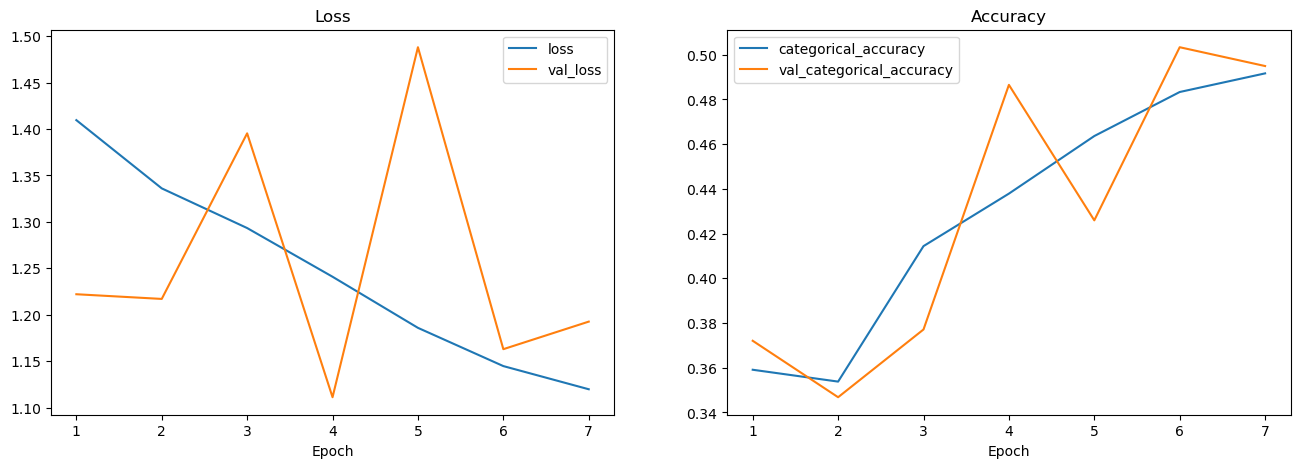

In [517]:
epoch=7

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history.history['categorical_accuracy'],label='categorical_accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
## visualization of model validation and train result

In [518]:
model_GRU_tun.evaluate(val_dataset)

10/10 [==============================] - 0s 36ms/step - loss: 1.1111 - categorical_accuracy: 0.4865


[1.1111308336257935, 0.48653197288513184]

As we can see that using the Near-Miss sampling still result in underfitting. So we can conclude that the model that we made is not good enough. 